In [1]:
import gridgeo

gridgeo.__version__

'0.1.0'

### Gridgeo will fail with non-compliant (s/u-grid) grid types

In [2]:
url = ('http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/'
       'sabgom/SABGOM_Forecast_Model_Run_Collection_best.ncd')

try:
    grid = gridgeo.GridGeo(url)
except ValueError as e:
    print(e)

Found more than 1 grid.
[<type 'netCDF4._netCDF4.Variable'>
float64 lon_rho(eta_rho, xi_rho)
    units: degrees_east
    long_name: longitude of RHO-points
    standard_name: longitude
    field: lon_rho, scalar
    _CoordinateAxisType: Lon
unlimited dimensions: 
current shape = (320, 440)
filling off
, <type 'netCDF4._netCDF4.Variable'>
float64 lon_u(eta_u, xi_u)
    units: degrees_east
    long_name: longitude of U-points
    standard_name: longitude
    field: lon_u, scalar
    _CoordinateAxisType: Lon
unlimited dimensions: 
current shape = (320, 439)
filling off
, <type 'netCDF4._netCDF4.Variable'>
float64 lon_v(eta_v, xi_v)
    units: degrees_east
    long_name: longitude of V-points
    standard_name: longitude
    field: lon_v, scalar
    _CoordinateAxisType: Lon
unlimited dimensions: 
current shape = (319, 440)
filling off
, <type 'netCDF4._netCDF4.Variable'>
float64 lon_psi(eta_psi, xi_psi)
    units: degrees_east
    long_name: longitude of PSI-points
    standard_name: longi

In [3]:
import iris

cube = iris.load_cube(url, 'sea_water_potential_temperature')

/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/cf.py:1046: UserWarning: Ignoring formula terms variable u'h' referenced by data variable u'v' via variable u's_rho': Dimensions (u'eta_rho', u'xi_rho') do not span (u'time', u's_rho', u'eta_v', u'xi_v')
  warnings.warn(msg)
/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/cf.py:1046: UserWarning: Ignoring formula terms variable u'zeta' referenced by data variable u'v' via variable u's_rho': Dimensions (u'time', u'eta_rho', u'xi_rho') do not span (u'time', u's_rho', u'eta_v', u'xi_v')
  warnings.warn(msg)
/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/cf.py:1046: UserWarning: Ignoring formula terms variable u'h' referenced by data variable u'u' via variable u's_rho': Dimensions (u'eta_rho', u'xi_rho') do not span (u'time', u's_rho', u'eta_u', u'xi_u')
  warnings.warn(msg)
/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/cf.py:104

### but we can still create a GridGeo object using an iris cube

(The iris cube is a CF-interpretation and we can take advantage of that to
extract the grid information.)

In [4]:
grid = gridgeo.GridGeo(cube)
grid

<iris 'Cube' of sea_water_potential_temperature / (Celsius) (time: 328; ocean_s_coordinate_g1: 36; -- : 320; -- : 440)>

### The grid object a `__geo_interface__` property

In [5]:
grid.__geo_interface__.keys()

['type', 'coordinates']

### There are many ways to visualize the grid

### The grid outline

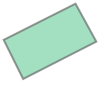

In [6]:
grid.outline

### The grid cells

(Note that displaying all the polygons is an expensive operation and might crash the browser.)

There are 140041 polygons.


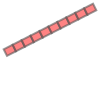

In [7]:
print('There are {} polygons.'.format(len(grid.polygons)))

grid.polygons[0:10]

### A numpy array (raster image)

In [8]:
img = grid.raster

type(img)

/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


numpy.ndarray

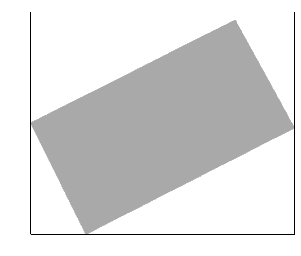

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(img)
_ = ax.axis('off')

### The `properties` and `methods`

 ### The original grid `object`

In [10]:
grid.grid

### The mesh type

In [11]:
grid.mesh

'non-compliant'

### The original file/object reference

In [12]:
grid.nc

<iris 'Cube' of sea_water_potential_temperature / (Celsius) (time: 328; ocean_s_coordinate_g1: 36; -- : 320; -- : 440)>

### The `to_geojson()` method returns a styled geojson-like `dict`
(See https://github.com/mapbox/simplestyle-spec/tree/master/1.1.0 for styling options.)

In [13]:
properties = dict(fill='#fd7d11',
                  fill_opacity=0.2,
                  stroke_opacity=1)

geojson = grid.to_geojson(**properties)

geojson['properties']

{'description': '',
 'fill': '#fd7d11',
 'fill-opacity': 0.6,
 'marker-color': '7e7e7e',
 'marker-size': 'medium',
 'marker-symbol': '',
 'stroke': '555555',
 'stroke-opacity': 1,
 'stroke-width': 2,
 'title': 'non-compliant'}

### Saving the grid to as geojson file

In [14]:
import json

kw = dict(sort_keys=True, indent=4, separators=(',', ': '))
with open('grid.geojson','w') as f:
    json.dump(geojson, f, **kw)

### or as a shapefile

In [15]:
import fiona

schema = {'geometry': 'MultiPolygon',
          'properties': {'name': 'str:{}'.format(len(grid.mesh))}}

with fiona.open('grid.shp', 'w', 'ESRI Shapefile', schema) as f:
    f.write({'geometry': grid.__geo_interface__,
             'properties': {'name': grid.mesh}})